In [1]:
# ==============================================================================
# Imports
# ==============================================================================

# This is needed so that python finds the utils
import sys
sys.path.append("/home/gf332/miracle-compession/code")
sys.path.append("/home/gf332/miracle-compession/code/compression")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code/compression")
sys.path.append("/homes/gf332/miracle-compession/code")
sys.path.append("/homes/gf332/miracle-compession/code/compression")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd

from imageio import imwrite

import argparse
import os, glob
import json
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow_probability as tfp
tfq = tf.quantization 
tfd = tfp.distributions
tf.enable_eager_execution()

tfe = tf.contrib.eager
tfs = tf.contrib.summary
tfs_logger = tfs.record_summaries_every_n_global_steps

from pipeline import clic_input_fn, create_model, optimizers, models
from utils import is_valid_file, setup_eager_checkpoints_and_restore
from load_data import load_and_process_image, create_random_crops, download_process_and_load_data
from coding import ArithmeticCoder
from binary_io import write_bin_code, read_bin_code, to_bit_string, from_bit_string
from greedy_compression import code_grouped_greedy_sample, decode_grouped_greedy_sample
from greedy_compression import code_grouped_importance_sample, decode_grouped_importance_sample

from kodak import download_kodak_dataset, create_kodak_dataset, create_kodak_comparison_dataset, compress_kodak

from two_stage_vae import ClicTwoStageVAE
from ladder_network import ClicNewLadderCNN

from compression import coded_sample, decode_sample

np.seterr(all="raise");

W0726 15:25:39.122817 140042420279040 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0726 15:25:39.125947 140042420279040 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/pipeline.py:20: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.

W0726 15:25:39.142736 140042420279040 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0726 15:25:39.195755 140042420279040 deprecation_wrapper.py:

In [2]:
!ls /scratch/gf332/miracle-models

ladder_192_128			     new_ladder_smaller_latent_space
ladder_48_24_learn_log_gamma	     new_ladder_small_latent_space
ladder_48_24_learn_log_gamma_1_beta  new_ladder_test
ladder_48_24_residual		     new_ladder_with_sigmoid_out
new_ladder_24_24_latent_space	     new_ladder_with_sigmoid_out_bigger_beta
new_ladder_4_4_latent_space	     two_stage_64_latents
new_ladder_48_24_latent_space


In [4]:
model_key="ladder"
model_dir="/scratch/gf332/miracle-models/ladder_48_24_residual/"
config_path="/homes/gf332/miracle-compession/config/clic/ladder/ladder_48_24_residual.json"
is_training=False

# ==========================================================================
# Configuration
# ==========================================================================


with open(config_path, "r") as cfg_file:
    config = json.load(cfg_file)

# ==========================================================================
# Create VAE model
# ==========================================================================

vae = create_model(model_key, config, train_stage=1)

optimizer = optimizers[config["optimizer"]](config["learning_rate"])

# ==========================================================================
# Define Checkpoints
# ==========================================================================

global_step = tf.train.get_or_create_global_step()

if isinstance(vae, tuple):
    trainable_vars = vae[0].get_all_variables() + vae[1].get_all_variables() + (global_step,)

else:
    trainable_vars = vae.get_all_variables() + (global_step,)

checkpoint_dir = os.path.join(model_dir, "checkpoints")

checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
    variables=trainable_vars,
    checkpoint_dir=checkpoint_dir,
    checkpoint_name=config["checkpoint_name"])

Checkpoint found at /scratch/gf332/miracle-models/ladder_48_24_residual/checkpoints/_ckpt-33, restoring...
Model restored!


In [4]:
!ls /scratch/gf332/

datasets  miracle-models


In [7]:
vae[1].decode(vae[1].prior.sample())
vae[0].prior.sample()

TypeError: 'ClicNewLadderCNN' object does not support indexing

In [5]:
train_image_dir = "/scratch/gf332/datasets/miracle_image_compression/train/"
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"

train_image_paths = glob.glob(train_image_dir + "/*.png")
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

johns_image = "/homes/gf332/miracle-compession/img/poster/new_court.jpeg"
thong_vo_image = '/scratch/gf332/datasets/miracle_image_compression/valid/thong-vo-428.png'

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(thong_vo_image)
    
    im = tf.convert_to_tensor(train_img_1[None, ...])
    # two stage vae
    if isinstance(vae, tuple):
        z = vae[0].encode(im)
        z_mean = vae[0].posterior.loc
        z_ = vae[1](z_mean)
        encoded_1 = vae[0].decode(z_)
    
    else:
        encoded_1 = vae(im)
    
    encoded_1 = tf.clip_by_value(encoded_1, 0., 1.)
    ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(train_img_1), encoded_1, 1.)
    psnr = tf.image.psnr(tf.convert_to_tensor(train_img_1), encoded_1, max_val=1.0).numpy()[0]
    
    print("MS-SSIM: {:.4f}".format(ms_ssim.numpy()[0]))
    print("PSNR: {:.4f}".format(psnr))
    
    if isinstance(vae, tuple):
        kld = tf.reduce_sum(vae[1].kl_divergence) / np.log(2)
        
    else:
        kld = sum([tf.reduce_sum(x) for x in vae.kl_divergence]) / np.log(2)
        
    print("KL divergence: {:.2f} bits, {:.2f} bytes".format(kld, kld / 8))

MS-SSIM: 0.9499
PSNR: 26.1224
KL divergence: 251222.62 bits, 31402.83 bytes


In [ ]:
if isinstance(vae, tuple):
    z_gen = vae[1].prior.sample()
    z_gen = vae[1].decode(z_gen)
    
    #z_gen = vae[0].prior.sample()
    im_gen = vae[0].decode(z_gen)
    
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(im_gen))
plt.title("Generated", fontsize=18)
plt.axis("off")
plt.show()

In [6]:
244255.33 + 2 * np.log(244255.33 + 1)

244280.14194697127

In [7]:
244280/ 8

30535.0

In [8]:
with tf.device("CPU:0"):
    train_img_1 = load_and_process_image(thong_vo_image)
    print(train_img_1.shape.as_list())

[790, 1264, 3]


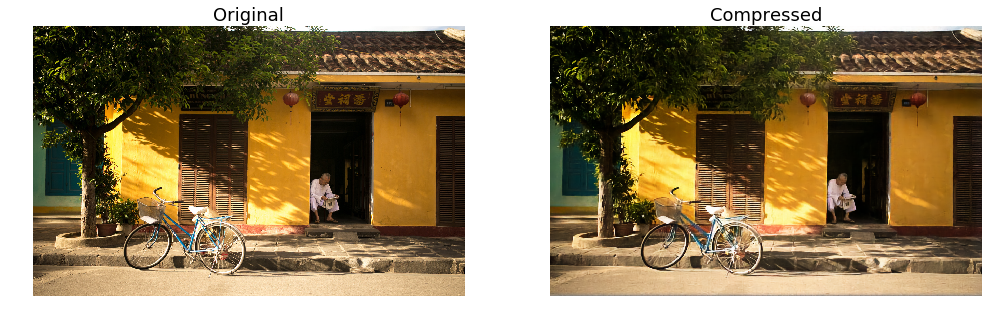

In [6]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(train_img_1)
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(encoded_1).numpy())
plt.axis("off")

plt.show()

In [7]:
from imageio import imwrite

clipped = np.squeeze(encoded_1.numpy())
clipped[clipped > 1] = 1
clipped[clipped < 0] = 0

clipped *= 255

clipped = clipped.astype(np.uint8)

im_path = "/homes/gf332/miracle-compession/img/clic/thong_vo_residual_ladder.png"

if not os.path.exists(im_path):
    imwrite(im_path, clipped)
else:
    print("{} already exists".format(im_path))

# Get results on the whole CLIC validation dataset

In [8]:
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

results = []

with tf.device("CPU:0"):
    for im_path in tqdm(valid_image_paths):

        image = tf.convert_to_tensor(load_and_process_image(valid_image_paths[0]))[None, ...]

        reconstruction = vae(image)
        reconstruction = tf.clip_by_value(reconstruction, 0., 1.)

        ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(image), reconstruction, 1.).numpy()[0]
        psnr = tf.image.psnr(image, reconstruction, max_val=1.0).numpy()[0]

        results.append((im_path, ms_ssim, psnr))

In [26]:
paths, ssims, psnrs = zip(*results)

ssim_mean = np.mean(ssims)
ssim_std = np.std(ssims)

psnrs_mean = np.mean(psnrs)
psnrs_std = np.std(psnrs)

print("MS-SSIM: {:.4f} \pm {:.4f}".format(ssim_mean, ssim_std))
print("PSNR: {:.2f} \pm {:.4f}".format(psnrs_mean, psnrs_std))

MS-SSIM: 0.9667 \pm 0.0001
PSNR: 32.49 \pm 0.0054


# Actual Compression bit, for real this time

In [9]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[4])
    im = tf.convert_to_tensor(train_img_1[None, ...])
    latents = vae.encode(im)
    
    res = vae.decode(latents)

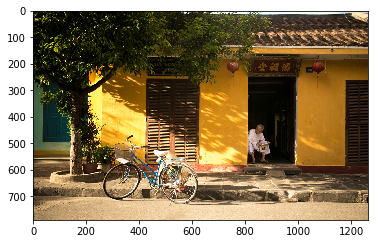

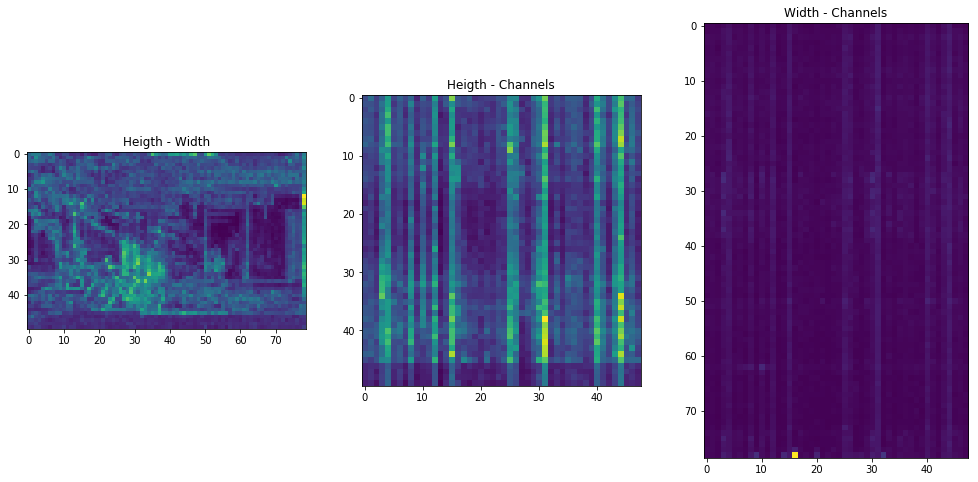

In [10]:
kl_1 = vae.kl_divergence[0][0]
kl_2 = vae.kl_divergence[1][0]

kl_1_hw = tf.reduce_sum(kl_1, axis=2)
kl_1_hc = tf.reduce_sum(kl_1, axis=1)
kl_1_wc = tf.reduce_sum(kl_1, axis=0)


plt.imshow(tf.squeeze(im))

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_1_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_1_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_1_wc, interpolation="nearest", aspect="equal", origin="upper")



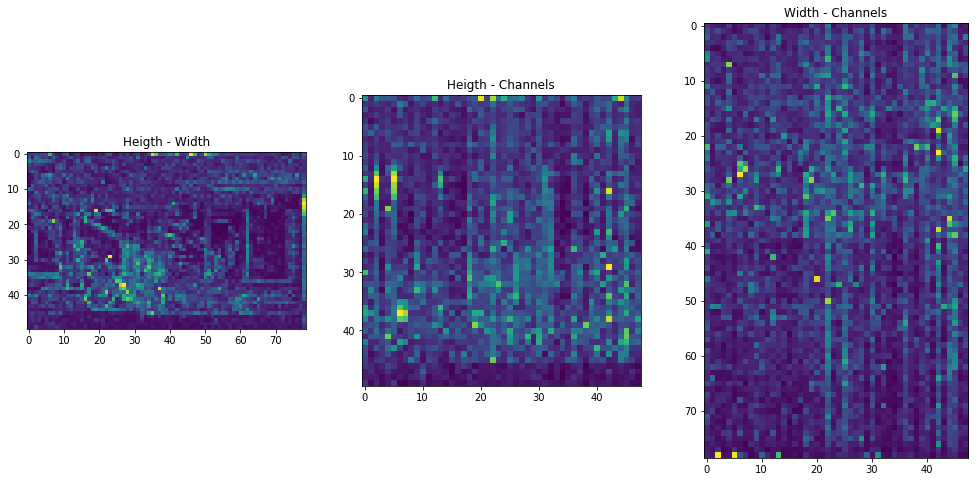

In [38]:
kl_1_hw = tf.reduce_max(kl_1, axis=2)
kl_1_hc = tf.reduce_max(kl_1, axis=1)
kl_1_wc = tf.reduce_max(kl_1, axis=0)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_1_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_1_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_1_wc, interpolation="nearest", aspect="equal", origin="upper")

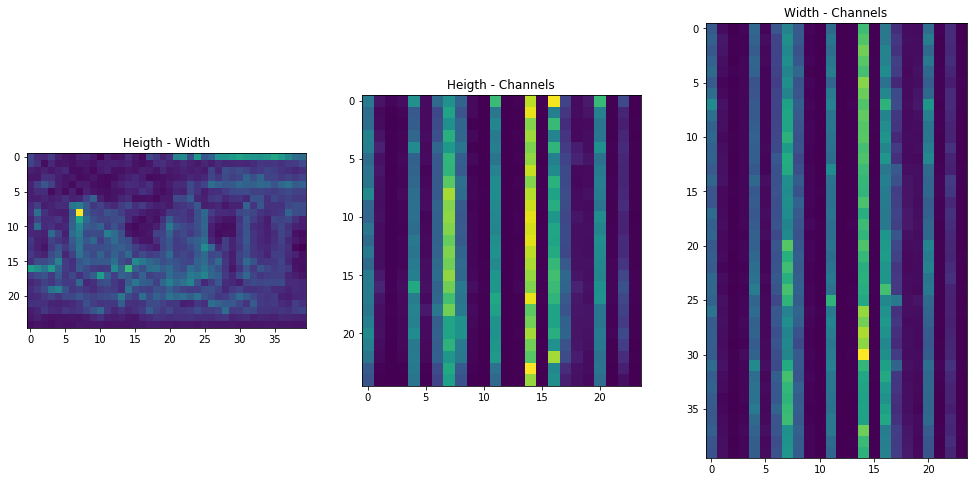

In [39]:
kl_2_hw = tf.reduce_sum(kl_2, axis=2)
kl_2_hc = tf.reduce_sum(kl_2, axis=1)
kl_2_wc = tf.reduce_sum(kl_2, axis=0)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_2_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_2_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_2_wc, interpolation="nearest", aspect="equal", origin="upper")

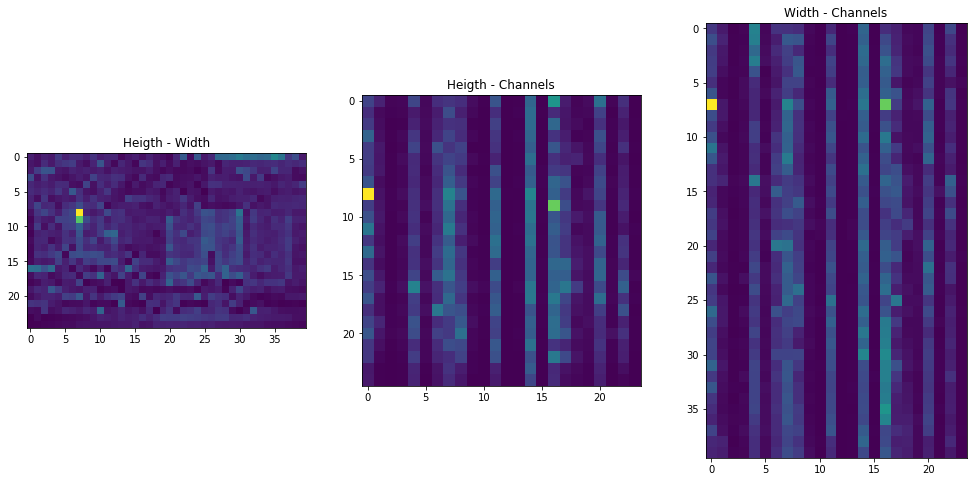

In [40]:
kl_2_hw = tf.reduce_max(kl_2, axis=2)
kl_2_hc = tf.reduce_max(kl_2, axis=1)
kl_2_wc = tf.reduce_max(kl_2, axis=0)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_2_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_2_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_2_wc, interpolation="nearest", aspect="equal", origin="upper")

In [14]:
seed = 42
miracle_bits = 8

coded_samps = coded_sample(proposal=vae.latent_priors[1], 
                           target=vae.latent_posteriors[1], 
                           seed=seed, 
                           n_points=30, 
                           miracle_bits=miracle_bits,
                           outlier_mode="importance_sample")

100%|██████████| 256/256 [00:04<00:00, 52.25it/s]

Accepted 99.03% of samples, 639.0 latents not accepted.


In [6]:
from compression import rejection_sample

seed = 42
miracle_bits = 8

result = rejection_sample(p=vae.latent_priors[1],
                          q=vae.latent_posteriors[1],
                          n_points=30,
                          num_draws=2**miracle_bits,
                          calculate_importance_weights=True,
                          seed=seed)

W0708 14:52:00.457897 140506635159296 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/compression.py:34: The name tf.random.set_random_seed is deprecated. Please use tf.compat.v1.random.set_random_seed instead.

W0708 14:52:00.932274 140506635159296 deprecation.py:323] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/tensorflow_probability/python/internal/special_math.py:251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 256/256 [00:01<00:00, 170.64it/s]


In [7]:
tf.reduce_max(result[3])

<tf.Tensor: id=26887, shape=(), dtype=float32, numpy=255.0>

In [10]:
decoded_samps = decode_sample(coded_sample=coded_samps,
                              proposal=vae.latent_priors[1], 
                              seed=seed, 
                              n_points=30, 
                              miracle_bits=miracle_bits, 
                              outlier_mode="quantize")

100%|██████████| 256/256 [00:00<00:00, 473.54it/s]


In [11]:
coded_samps_ = coded_sample(proposal=vae.latent_priors[0], 
                           target=vae.latent_posteriors[0], 
                           seed=seed, 
                           n_points=30, 
                           miracle_bits=miracle_bits)

100%|██████████| 256/256 [00:37<00:00,  7.01it/s]

Accepted 99.59% of samples, 2153.0 latents not accepted.


In [12]:
decoded_samps_ = decode_sample(coded_sample=coded_samps_,
                              proposal=vae.latent_priors[0], 
                              seed=seed, 
                              n_points=30, 
                              miracle_bits=miracle_bits, 
                              outlier_mode="quantize")

100%|██████████| 256/256 [00:00<00:00, 326.79it/s]


In [13]:
unique, _, counts = tf.unique_with_counts(coded_samps)


unique = unique.numpy()
counts = counts.numpy()

np.all((coded_samps < 256).numpy() == accepted.numpy())

NameError: name 'accepted' is not defined

<BarContainer object of 255 artists>

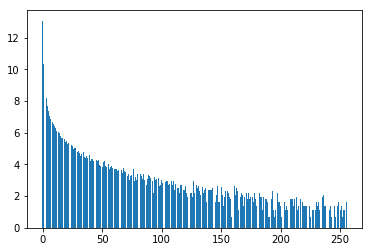

In [87]:
plt.bar(unique[unique < 256], np.log(counts[unique < 256]))

In [10]:
latent_shape_ = vae.latent_priors[0].loc.shape.as_list()
latent_shape = vae.latent_priors[1].loc.shape.as_list()
latent_shape_

[1, 86, 128, 64]

In [9]:
with tf.device("CPU:0"):
    decoded = vae.decode(latents)
#     decoded_ = tf.nn.sigmoid(vae.decode((tf.reshape(decoded_samps, latent_shape), 
#                                          tf.reshape(decoded_samps_, latent_shape_))))
    

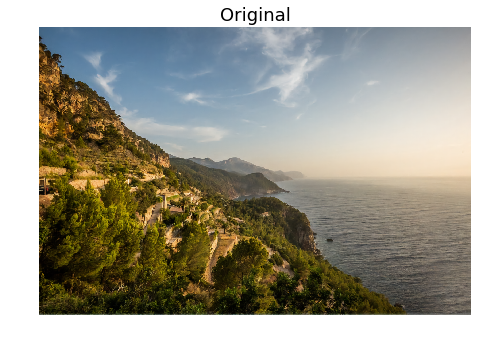

In [10]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(decoded).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

# plt.subplot(122)
# plt.title("Compressed", fontsize=18)
# plt.imshow(tf.squeeze(decoded_).numpy())
# plt.axis("off")

plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

prob_mass = np.load("../../probability_mass_48_24.npy")

total_mass = np.sum(prob_mass)

log_prob_mass = np.log(prob_mass)

log_total_mass = np.log(total_mass)

<BarContainer object of 256 artists>

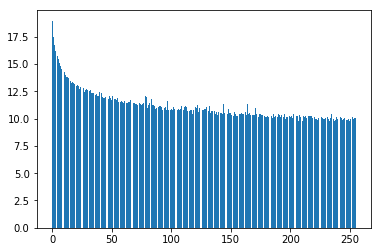

In [10]:
plt.bar(np.arange(len(prob_mass)), np.log(prob_mass))

In [20]:
log_prob_mass[0] - log_total_mass

-0.11732173697385306

In [12]:
100 * 2**16 / np.sum(prob_mass)

0.012697403590212564

In [7]:
num_bits = 2**16
gamma = 100

P = gamma * np.ones(num_bits)


In [7]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    for i, im_path in enumerate(valid_image_paths):
        
        im = load_and_process_image(im_path)
        print(i, im_path, im.shape)

0 /scratch/gf332/datasets/miracle_image_compression/valid/stefan-kunze-26931.png (1367, 2048, 3)
1 /scratch/gf332/datasets/miracle_image_compression/valid/sergey-zolkin-1045.png (1365, 2048, 3)
2 /scratch/gf332/datasets/miracle_image_compression/valid/wojciech-szaturski-3611.png (1325, 1988, 3)
3 /scratch/gf332/datasets/miracle_image_compression/valid/juskteez-vu-1041.png (1725, 1145, 3)
4 /scratch/gf332/datasets/miracle_image_compression/valid/thong-vo-428.png (790, 1264, 3)
5 /scratch/gf332/datasets/miracle_image_compression/valid/ales-krivec-15949.png (1188, 2048, 3)
6 /scratch/gf332/datasets/miracle_image_compression/valid/amy-zhang-15940.png (915, 1632, 3)
7 /scratch/gf332/datasets/miracle_image_compression/valid/todd-quackenbush-27493.png (1033, 2048, 3)
8 /scratch/gf332/datasets/miracle_image_compression/valid/alejandro-escamilla-6.png (1339, 2048, 3)
9 /scratch/gf332/datasets/miracle_image_compression/valid/sergey-zolkin-21232.png (1028, 1542, 3)
10 /scratch/gf332/datasets/mira

W0721 15:34:11.957932 139902008366848 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/compression.py:34: The name tf.random.set_random_seed is deprecated. Please use tf.compat.v1.random.set_random_seed instead.

W0721 15:34:11.967761 139902008366848 deprecation.py:323] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/tensorflow_probability/python/internal/special_math.py:251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 256/256 [00:04<00:00, 52.56it/s]


Accepted 97.39% of samples, 627.0 latents not accepted.


100%|██████████| 256/256 [00:18<00:00, 13.75it/s]


Accepted 98.88% of samples, 2132.0 latents not accepted.
Outlier / Miracle Mass Ratio: 0.0069


 10%|▉         | 20888/213601 [00:00<00:00, 208871.24it/s]

Depth of symbol tree: 17


100%|██████████| 213601/213601 [00:00<00:00, 327107.26it/s]


Expected code length: 492974.02 bits
Actual code length: 711211 bits
[42, 30, 50, 79, 25, 40]
Outlier / Miracle Mass Ratio: 0.0069
Depth of symbol tree: 17
Remaining bits at end of code: -3


100%|██████████| 256/256 [00:01<00:00, 163.74it/s]


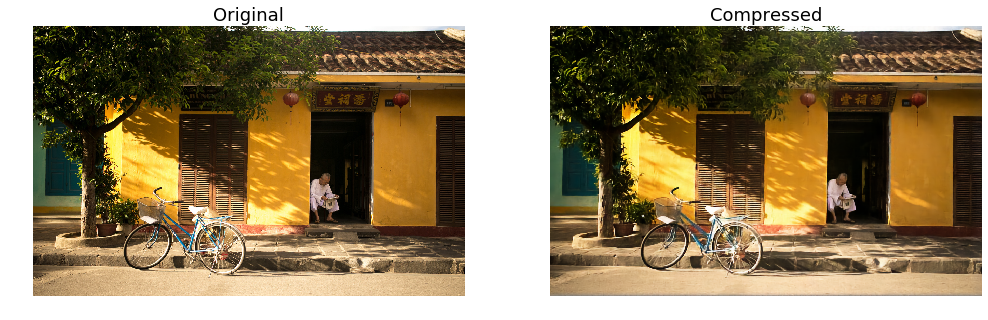

In [5]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

comp_file_path = "thong_vo_quant_bad.miracle"

seed = 42
miracle_bits = 8
outlier_mode = "quantize"
gamma=30

probability_mass = np.load("../../probability_mass_48_24.npy")

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[4])
    im = tf.convert_to_tensor(im[None, ...])
    vae.code_image(image=im,
                   seed=seed,
                   gamma=gamma,
                   miracle_bits=miracle_bits,
                   probability_mass=probability_mass,
                   comp_file_path=comp_file_path,
                   outlier_mode=outlier_mode,
                   verbose=True)
    
    reconstruction = vae.decode_image(comp_file_path=comp_file_path,
                                      probability_mass=probability_mass,
                                      miracle_bits=miracle_bits,
                                      outlier_mode=outlier_mode,
                                      verbose=True)
    
    
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(im).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(reconstruction).numpy())
plt.axis("off")

plt.show()

In [8]:
1 / np.log(2)

1.4426950408889634

In [10]:
np.prod([790, 1264])

998560

In [12]:
(103 * 8 * 2**10) / (1.8 * 8 * 2**20)

0.05588107638888889

In [3]:
(86.2 * 8 * 2**10) / np.prod([790, 1264])

0.7071687229610639

In [14]:
244280 / np.prod([790, 1264])

0.24463227046947605

# Miguel's method

In [9]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[22])
    latents = vae.encode(tf.convert_to_tensor(im[None, ...]))
    
    res = vae.decode(latents)

In [10]:
n_bits_per_step = 14
n_steps = 30
seed = 2
rho = 1.

# s1, c1, gi1 = code_grouped_greedy_sample(target=vae.latent_posteriors[1], 
#                                                          proposal=vae.latent_priors[1], 
#                                                          n_bits_per_step=n_bits_per_step, 
#                                                          n_steps=n_steps, 
#                                                          seed=seed, 
#                                                          max_group_size_bits=6,
#                                                          adaptive=True,
#                                                          backfitting_steps=0,
#                                                          rho=rho)

# s1_ = decode_grouped_greedy_sample(c1,
#                                    gi1,
#                                    vae.latent_priors[1], 
#                                    n_bits_per_step, 
#                                    n_steps, 
#                                    seed,
#                                    adaptive=True,
#                                    rho=rho)
n_bits_per_group = 20
max_group_size_bits = 4
dim_kl_bit_limit = 12

s1, c1, gi1, outlier_extras = code_grouped_importance_sample(target=vae.latent_posteriors[1], 
                                                             proposal=vae.latent_priors[1], 
                                                             n_bits_per_group=n_bits_per_group, 
                                                             seed=seed, 
                                                             max_group_size_bits=max_group_size_bits,
                                                             dim_kl_bit_limit=dim_kl_bit_limit)

s1_ = decode_grouped_importance_sample(bitcode=c1, 
                                         group_start_indices=gi1[:-1],
                                         proposal=vae.latent_priors[1], 
                                         n_bits_per_group=n_bits_per_group,
                                         seed=seed,
                                         outlier_indices=outlier_extras[0],
                                         outlier_samples=outlier_extras[1])


  1%|▏         | 7/483 [00:00<00:07, 63.40it/s]

Total KL to split up: 7881.63 bits, maximum bits per group: 20, estimated number of groups: 395.0,coding 4608 dimensions
18.55568649071493


100%|██████████| 483/483 [00:01<00:00, 465.09it/s]


In [11]:
np.all(s1_.numpy() == s1.numpy())

False

In [12]:
s1_r = tf.cast(tf.reshape(s1_, vae.latent_priors[1].loc.shape.as_list()), tf.float32)

print(s1_r.shape.as_list())
print(vae.latent_posteriors[1].sample().shape.as_list())

second_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(s1_r))
average_sample_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(vae.latent_posteriors[1].sample()))

print("Avg greedy sample log likelihood on level 2: {:.4f}".format(second_avg_log_lik))
print("Avg sample log likelihood on level 2: {:.4f}".format(average_sample_lik))

[1, 12, 16, 24]
[1, 12, 16, 24]
Avg greedy sample log likelihood on level 2: -0.3879
Avg sample log likelihood on level 2: -0.2355


In [13]:
kl_divs = tf.reshape(tfd.kl_divergence(vae.latent_posteriors[0], vae.latent_priors[0]), [-1]).numpy()
total_kl_bits = np.sum(kl_divs) / np.log(2)
total_kl_bits

23259.21398212442

In [15]:
r = vae.decode((tf.reshape(s1_, vae.latent_priors[1].loc.shape.as_list()), tf.zeros_like(latents[1])))
#vae.decode(latents)
kl_divs = tf.reshape(tfd.kl_divergence(vae.latent_posteriors[0], vae.latent_priors[0]), [-1]).numpy()
total_kl_bits = np.sum(kl_divs) / np.log(2)
total_kl_bits

27038.745310894552

In [16]:
s2, c2, gi2 = code_grouped_greedy_sample(target=vae.latent_posteriors[0], 
                                         proposal=vae.latent_priors[0], 
                                         n_bits_per_step=n_bits_per_step, 
                                         n_steps=n_steps, 
                                         seed=seed, 
                                         max_group_size_bits=12, # group size limited to 2^max_group_size_bits
                                         backfitting_steps=0,
                                         adaptive=True)

  0%|          | 0/65 [00:00<?, ?it/s]

Total KL to split up: 27038.75 bits, maximum bits per group: 420, estimated number of groups: 65.0,coding 36864 dimensions


100%|██████████| 65/65 [00:19<00:00,  2.57it/s]


In [17]:
s2_ = decode_grouped_greedy_sample(c2,
                                   gi2,
                                   vae.latent_priors[0], 
                                   n_bits_per_step, 
                                   n_steps, 
                                   seed, 
                                   adaptive=True,
                                   rho=rho)

100%|██████████| 66/66 [00:06<00:00,  9.57it/s]


In [18]:
np.all(s2_.numpy() == s2.numpy())

True

In [19]:
s2_r = tf.cast(tf.reshape(s2_, vae.latent_priors[0].loc.shape.as_list()), tf.float32)
s1_r = tf.cast(tf.reshape(s1_, vae.latent_priors[1].loc.shape.as_list()), tf.float32)

print(s2_r.shape.as_list())
print(s1_r.shape.as_list())
print(vae.latent_posteriors[0].sample().shape.as_list())
print(vae.latent_posteriors[1].sample().shape.as_list())

r= vae(tf.convert_to_tensor(im[None, ...]))

first_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[0].log_prob(s2_r))
second_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(s1_r))
first_sample_avg = tf.reduce_mean(vae.latent_posteriors[0].log_prob(vae.latent_posteriors[0].sample()))

print("Avg greedy sample log likelihood on level 1: {:.4f}".format(first_avg_log_lik))
print("Avg sample log likelihood on level 1: {:.4f}".format(first_sample_avg))
print("Avg greedy sample log likelihood on level 2: {:.4f}".format(second_avg_log_lik))

[1, 24, 32, 48]
[1, 12, 16, 24]
[1, 24, 32, 48]
[1, 12, 16, 24]
Avg greedy sample log likelihood on level 1: -0.1121
Avg sample log likelihood on level 1: -0.0266
Avg greedy sample log likelihood on level 2: -0.3879


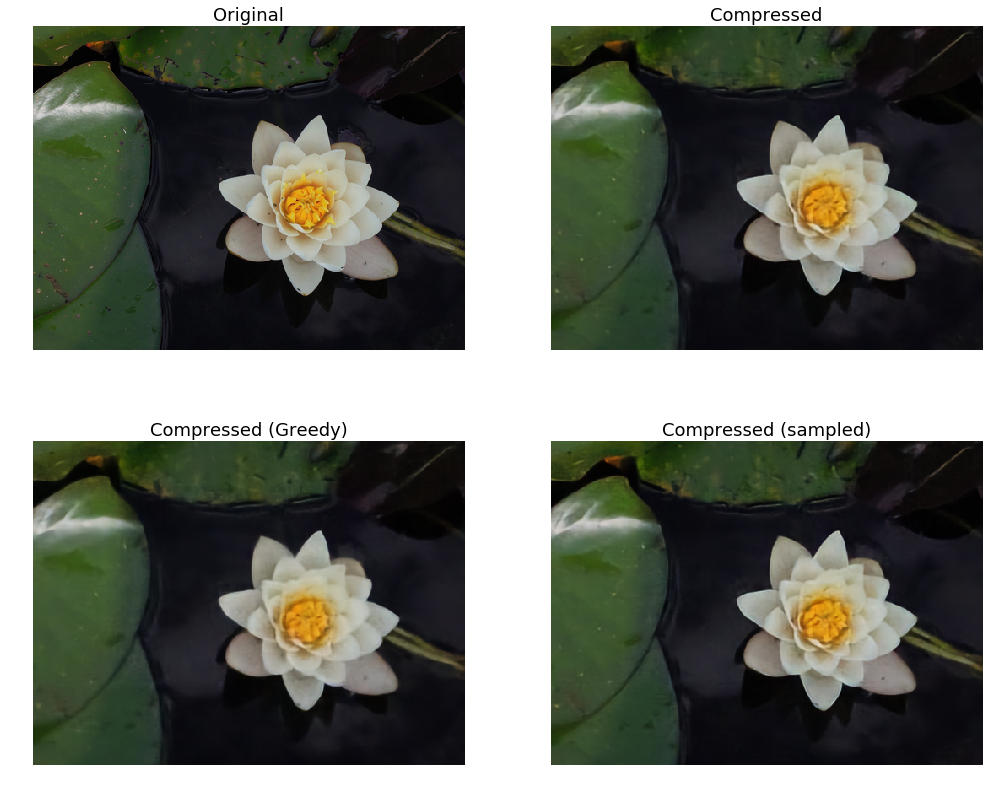

In [20]:
reconstruction = vae.decode((s1_r, s2_r))
mean_reconstruction = vae.decode((vae.latent_posteriors[1].loc, vae.latent_posteriors[0].sample()))

plt.figure(figsize=(17, 14))
plt.subplot(221)
plt.imshow(tf.squeeze(im).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(222)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(res).numpy())
plt.axis("off")

plt.subplot(223)
plt.title("Compressed (Greedy)", fontsize=18)
plt.imshow(tf.squeeze(reconstruction).numpy())
plt.axis("off")

plt.subplot(224)
plt.title("Compressed (sampled)", fontsize=18)
plt.imshow(tf.squeeze(mean_reconstruction).numpy())
plt.axis("off")

plt.savefig("compression_comparison.png")

plt.show()

In [46]:
write_bin_code(c1, "miguel.miracle")

In [47]:
#vae(im[None, ...])
#total_kl = sum([tf.reduce_sum(x) for x in vae.kl_divergence])
total_kl = tf.reduce_sum(vae.kl_divergence[0])

theoretical_byte_size = (total_kl + 2 * np.log(total_kl + 1)) / np.log(2) / 8
actual = os.path.getsize("miguel.miracle") + (len(gi1) + len(gi2)) * 3

print("Theoretical size: {:.2f} bytes".format(theoretical_byte_size))
print("Actual size: {:.2f} bytes".format(actual))
print("Efficiency: {:.3f}".format(actual / theoretical_byte_size))

Theoretical size: 2849.59 bytes
Actual size: 4329.00 bytes
Efficiency: 1.519


In [ ]:
train_img_1.shape

# Miguel's Method, as it's supposed to be used

In [7]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

comp_file_path = "lily_miguel.miracle"

n_bits_per_step = 14
n_steps = 30
seed = 1
rho = 1.
first_level_max_group_size_bits=12
second_level_max_group_size_bits=4

im = load_and_process_image(valid_image_paths[22])
im = tf.convert_to_tensor(im[None, ...])

samp2, samp1 = vae.code_image_greedy(image=im,
                                seed=seed,
                                rho=rho,
                                n_steps=n_steps,
                                n_bits_per_step=n_bits_per_step,
                                comp_file_path=comp_file_path,
                                backfitting_steps_level_1=0,
                                backfitting_steps_level_2=0,
                                use_log_prob=False,
                                first_level_max_group_size_bits=first_level_max_group_size_bits,
                                second_level_n_bits_per_group=20,
                                second_level_max_group_size_bits=second_level_max_group_size_bits,
                                second_level_dim_kl_bit_limit=12,
                                verbose=True)

r_no_back = vae.decode_image_greedy(comp_file_path=comp_file_path,
                                         verbose=True,
                                         rho=rho)

  2%|▏         | 8/483 [00:00<00:06, 76.11it/s]

Coding second level
Total KL to split up: 7881.63 bits, maximum bits per group: 20, estimated number of groups: 395.0,coding 4608 dimensions
Maximum group KL: 18.556


  0%|          | 0/65 [00:00<?, ?it/s]

Coding first level
Total KL to split up: 26981.30 bits, maximum bits per group: 420, estimated number of groups: 65.0,coding 36864 dimensions


 10%|▉         | 46/483 [00:00<00:00, 457.07it/s]

Image dimensions: [1, 384, 512, 3]
Theoretical size: 4383.89 bytes
Actual size: 5047.00 bytes
Extra information size: 355.00 bytes 7.03% of actual size
Actual size without extras: 4692.00 bytes
Efficiency: 1.151

First level theoretical size: 3376.21 bytes
First level actual (no extras) size: 3412.50 bytes
First level extras size: 99.00 bytes
First level Efficiency: 1.040
First level # of groups: 66
First level greedy sample average log likelihood: -0.1012
First level average sample log likelihood on level 1: -0.0230

Second level theoretical size: 1010.70 bytes
Second level actual (no extras) size: 1207.50 bytes
Second level extras size: 242.00 bytes
12 outliers were not compressed (higher than 12 bits of KL)
Second level Efficiency: 1.434
Second level # of groups: 484
Second level greedy sample average log likelihood: -0.3956
Second level average sample log likelihood on level 1: -0.2428

0.2054 bits / pixel
Decoding second level


  3%|▎         | 2/66 [00:00<00:06, 10.12it/s]

Decoding first level


100%|██████████| 66/66 [00:06<00:00,  9.97it/s]


In [ ]:
q1_scale = tf.reshape(vae.latent_posteriors[0].scale, [-1]).numpy()
q2_scale = tf.reshape(vae.latent_posteriors[1].scale, [-1]).numpy()


q1_deviations = (tf.reshape(vae.latent_posteriors[0].loc, [-1]) - tf.squeeze(samp1)).numpy()
q2_deviations = (tf.reshape(vae.latent_posteriors[1].loc, [-1]) - tf.squeeze(samp2)).numpy()


num_bins = 200

plt.figure(figsize=(17, 17))
plt.subplot(221)
plt.title("First Level Standard Deviations")
plt.hist(q1_scale, bins=num_bins)

plt.subplot(222)
plt.title("Second Level Standard Deviations")
plt.hist(q2_scale, bins=num_bins)

plt.subplot(223)
plt.title("First Level Deviations from the Mean")
plt.hist(q1_deviations, bins=num_bins)

plt.subplot(224)
plt.title("Second Level Deviations from the Mean")
plt.hist(q2_deviations, bins=num_bins)

plt.show()

Image dimensions: [1, 384, 512, 3]
Theoretical size: 4377.05 bytes
Actual size: 5047.00 bytes
Extra information size: 355.00 bytes 7.03% of actual size
Actual size without extras: 4692.00 bytes
Efficiency: 1.153

First level theoretical size: 3369.37 bytes
First level actual (no extras) size: 3412.50 bytes
First level extras size: 99.00 bytes
First level Efficiency: 1.042
First level # of groups: 66
First level greedy sample average log likelihood: -0.1005
First level average sample log likelihood on level 1: -0.0214

Second level theoretical size: 1010.70 bytes
Second level actual (no extras) size: 1207.50 bytes
Second level extras size: 242.00 bytes
12 outliers were not compressed (higher than 12 bits of KL)
Second level Efficiency: 1.434
Second level # of groups: 484
Second level greedy sample average log likelihood: -0.3960
Second level average sample log likelihood on level 1: -0.2428

0.2054 bits / pixel
Decoding second level

-----------------------------------

Image dimensions: [1, 384, 512, 3]
Theoretical size: 4383.89 bytes
Actual size: 5047.00 bytes
Extra information size: 355.00 bytes 7.03% of actual size
Actual size without extras: 4692.00 bytes
Efficiency: 1.151

First level theoretical size: 3376.21 bytes
First level actual (no extras) size: 3412.50 bytes
First level extras size: 99.00 bytes
First level Efficiency: 1.040
First level # of groups: 66
First level greedy sample average log likelihood: -0.0906
First level average sample log likelihood on level 1: -0.0230

Second level theoretical size: 1010.70 bytes
Second level actual (no extras) size: 1207.50 bytes
Second level extras size: 242.00 bytes
12 outliers were not compressed (higher than 12 bits of KL)
Second level Efficiency: 1.434
Second level # of groups: 484
Second level greedy sample average log likelihood: -0.3956
Second level average sample log likelihood on level 1: -0.2428

0.2054 bits / pixel
Decoding second level

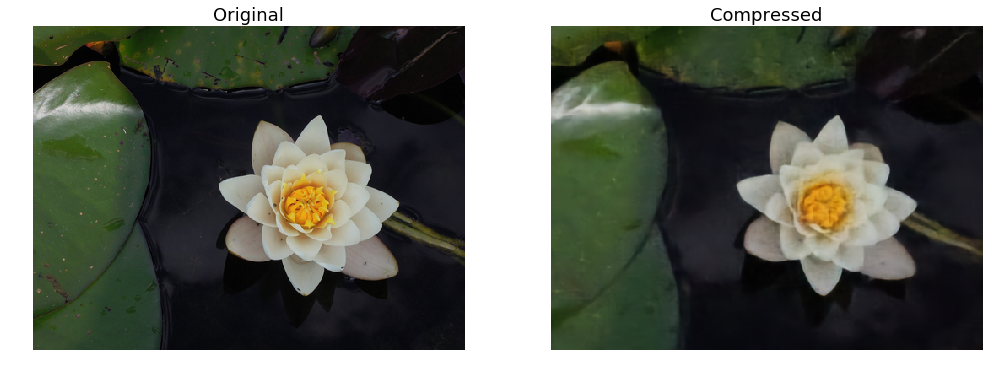

In [6]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(im).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(reconstruction.numpy())
plt.axis("off")

plt.show()

In [8]:
kodak_dataset_path = "../../data/kodak/"
rim = compress_kodak(vae=vae,
                     kodak_dataset_path=kodak_dataset_path,
                     reconstruction_subdir="backfit_3_lp_ladder_48_24", 
                     backfitting_steps_level_1=3,
                     use_log_prob=True,
                     theoretical=None,
                     verbose=False)

Creating reconstruction directory ../../data/kodak_miracle//backfit_3_lp_ladder_48_24


W0726 15:28:59.328371 140042420279040 deprecation.py:323] From /homes/gf332/miracle-compession/code/clic/greedy_compression.py:424: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  0%|          | 0/1004 [00:00<?, ?it/s]W0726 15:28:59.396898 140042420279040 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/greedy_compression.py:363: The name tf.random.set_random_seed is deprecated. Please use tf.compat.v1.random.set_random_seed instead.

  1%|          | 9/1004 [00:00<00:12, 80.55it/s]

Total KL to split up: 16759.01 bits, maximum bits per group: 20, estimated number of groups: 838.0,coding 9216 dimensions
Maximum group KL: 18.556


100%|██████████| 1004/1004 [00:13<00:00, 70.37it/s]


Total KL to split up: 101849.78 bits, maximum bits per group: 420, estimated number of groups: 243.0,coding 73728 dimensions


  5%|▍         | 46/1004 [00:00<00:02, 455.85it/s]

Decoding second level


  1%|          | 2/246 [00:00<00:18, 12.88it/s]

Decoding first level


100%|██████████| 246/246 [00:16<00:00, 15.14it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim01.png


  1%|          | 9/981 [00:00<00:11, 82.46it/s]

Total KL to split up: 15991.94 bits, maximum bits per group: 20, estimated number of groups: 800.0,coding 9216 dimensions
Maximum group KL: 18.556


100%|██████████| 981/981 [00:13<00:00, 73.55it/s]


Total KL to split up: 63492.16 bits, maximum bits per group: 420, estimated number of groups: 152.0,coding 73728 dimensions


  5%|▍         | 46/981 [00:00<00:02, 453.18it/s]

Decoding second level


  1%|▏         | 2/154 [00:00<00:09, 15.94it/s]

Decoding first level


100%|██████████| 154/154 [00:13<00:00, 11.19it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim02.png


  1%|          | 8/934 [00:00<00:12, 74.90it/s]

Total KL to split up: 15503.05 bits, maximum bits per group: 20, estimated number of groups: 776.0,coding 9216 dimensions
Maximum group KL: 18.556


100%|██████████| 934/934 [00:13<00:00, 71.14it/s]


Total KL to split up: 56698.61 bits, maximum bits per group: 420, estimated number of groups: 135.0,coding 73728 dimensions


  5%|▍         | 44/934 [00:00<00:02, 437.32it/s]

Decoding second level


  0%|          | 0/137 [00:00<?, ?it/s]

Decoding first level


100%|██████████| 137/137 [00:13<00:00, 10.25it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim03.png


  1%|          | 10/982 [00:00<00:10, 89.34it/s]

Total KL to split up: 16235.97 bits, maximum bits per group: 20, estimated number of groups: 812.0,coding 9216 dimensions
Maximum group KL: 18.557


100%|██████████| 982/982 [00:13<00:00, 72.12it/s]


Total KL to split up: 67019.45 bits, maximum bits per group: 420, estimated number of groups: 160.0,coding 73728 dimensions


  5%|▍         | 47/982 [00:00<00:01, 469.33it/s]

Decoding second level


  1%|          | 2/162 [00:00<00:11, 14.50it/s]

Decoding first level


100%|██████████| 162/162 [00:14<00:00, 11.51it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim04.png


  1%|          | 8/1140 [00:00<00:15, 74.44it/s]

Total KL to split up: 18802.79 bits, maximum bits per group: 20, estimated number of groups: 941.0,coding 9216 dimensions
Maximum group KL: 18.556


100%|██████████| 1140/1140 [00:15<00:00, 71.83it/s]


Total KL to split up: 111226.20 bits, maximum bits per group: 420, estimated number of groups: 265.0,coding 73728 dimensions


  4%|▎         | 42/1140 [00:00<00:02, 417.05it/s]

Decoding second level


  1%|          | 2/268 [00:00<00:18, 14.70it/s]

Decoding first level


100%|██████████| 268/268 [00:16<00:00, 15.92it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim05.png


  1%|          | 9/898 [00:00<00:10, 81.05it/s]

Total KL to split up: 14935.73 bits, maximum bits per group: 20, estimated number of groups: 747.0,coding 9216 dimensions
Maximum group KL: 18.557


100%|██████████| 898/898 [00:12<00:00, 69.91it/s]


Total KL to split up: 79501.47 bits, maximum bits per group: 420, estimated number of groups: 190.0,coding 73728 dimensions


  5%|▌         | 45/898 [00:00<00:01, 448.43it/s]

Decoding second level


  1%|          | 2/192 [00:00<00:11, 17.21it/s]

Decoding first level


100%|██████████| 192/192 [00:14<00:00, 13.69it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim06.png


  1%|          | 7/1031 [00:00<00:14, 69.94it/s]

Total KL to split up: 17082.36 bits, maximum bits per group: 20, estimated number of groups: 855.0,coding 9216 dimensions
Maximum group KL: 18.557


100%|██████████| 1031/1031 [00:14<00:00, 73.04it/s]


Total KL to split up: 78607.53 bits, maximum bits per group: 420, estimated number of groups: 188.0,coding 73728 dimensions


  5%|▍         | 47/1031 [00:00<00:02, 467.69it/s]

Decoding second level


  1%|          | 2/190 [00:00<00:16, 11.43it/s]

Decoding first level


100%|██████████| 190/190 [00:14<00:00, 12.81it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim07.png


  1%|          | 8/1102 [00:00<00:13, 79.04it/s]

Total KL to split up: 18077.65 bits, maximum bits per group: 20, estimated number of groups: 904.0,coding 9216 dimensions
Maximum group KL: 18.557


100%|██████████| 1102/1102 [00:14<00:00, 74.18it/s]


Total KL to split up: 115875.71 bits, maximum bits per group: 420, estimated number of groups: 276.0,coding 73728 dimensions


  4%|▍         | 48/1102 [00:00<00:02, 474.48it/s]

Decoding second level


  1%|          | 2/280 [00:00<00:16, 16.38it/s]

Decoding first level


100%|██████████| 280/280 [00:17<00:00, 15.80it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim08.png


W0726 15:57:25.619553 140042420279040 util.py:244] Unresolved object in checkpoint: (root).new_clic_ladder_cnn_1/conv_gdn_block/conv1/b:0
W0726 15:57:25.620709 140042420279040 util.py:244] Unresolved object in checkpoint: (root).new_clic_ladder_cnn_1/conv_gdn_block/conv1/w:0
W0726 15:57:25.621949 140042420279040 util.py:244] Unresolved object in checkpoint: (root).new_clic_ladder_cnn_1/conv_gdn_block_1/conv1/b:0
W0726 15:57:25.622493 140042420279040 util.py:244] Unresolved object in checkpoint: (root).new_clic_ladder_cnn_1/conv_gdn_block_1/conv1/w:0
W0726 15:57:25.623406 140042420279040 util.py:244] Unresolved object in checkpoint: (root).new_clic_ladder_cnn_1/conv_gdn_block_1_transpose/deconv1/b:0
W0726 15:57:25.624884 140042420279040 util.py:244] Unresolved object in checkpoint: (root).new_clic_ladder_cnn_1/conv_gdn_block_1_transpose/deconv1/w:0
W0726 15:57:25.625906 140042420279040 util.py:244] Unresolved object in checkpoint: (root).new_clic_ladder_cnn_1/encoder_level_1_conv_ds1/co

Total KL to split up: 14776.45 bits, maximum bits per group: 20, estimated number of groups: 739.0,coding 9216 dimensions
Maximum group KL: 18.557


100%|██████████| 888/888 [00:12<00:00, 70.93it/s]


Total KL to split up: 62851.16 bits, maximum bits per group: 420, estimated number of groups: 150.0,coding 73728 dimensions


  5%|▍         | 42/888 [00:00<00:02, 418.65it/s]

Decoding second level


  1%|▏         | 2/152 [00:00<00:12, 12.22it/s]

Decoding first level


100%|██████████| 152/152 [00:13<00:00, 13.57it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim09.png


  1%|          | 8/904 [00:00<00:12, 74.54it/s]

Total KL to split up: 15080.87 bits, maximum bits per group: 20, estimated number of groups: 755.0,coding 9216 dimensions
Maximum group KL: 18.556


100%|██████████| 904/904 [00:12<00:00, 66.72it/s]


Total KL to split up: 67776.52 bits, maximum bits per group: 420, estimated number of groups: 162.0,coding 73728 dimensions


  5%|▍         | 44/904 [00:00<00:01, 436.08it/s]

Decoding second level


  1%|          | 2/164 [00:00<00:12, 13.07it/s]

Decoding first level


100%|██████████| 164/164 [00:14<00:00, 11.68it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim10.png


  1%|          | 7/953 [00:00<00:14, 65.37it/s]

Total KL to split up: 15889.31 bits, maximum bits per group: 20, estimated number of groups: 795.0,coding 9216 dimensions
Maximum group KL: 18.553


100%|██████████| 953/953 [00:13<00:00, 70.37it/s]


Total KL to split up: 79035.60 bits, maximum bits per group: 420, estimated number of groups: 189.0,coding 73728 dimensions


  5%|▍         | 45/953 [00:00<00:02, 442.40it/s]

Decoding second level


  1%|          | 2/191 [00:00<00:17, 11.07it/s]

Decoding first level


100%|██████████| 191/191 [00:14<00:00, 12.92it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim11.png


  1%|          | 9/903 [00:00<00:10, 85.53it/s]

Total KL to split up: 14943.47 bits, maximum bits per group: 20, estimated number of groups: 748.0,coding 9216 dimensions
Maximum group KL: 18.557


100%|██████████| 903/903 [00:12<00:00, 72.19it/s]


Total KL to split up: 63228.29 bits, maximum bits per group: 420, estimated number of groups: 151.0,coding 73728 dimensions


  5%|▌         | 46/903 [00:00<00:01, 453.75it/s]

Decoding second level


  1%|▏         | 2/153 [00:00<00:09, 15.43it/s]

Decoding first level


100%|██████████| 153/153 [00:13<00:00, 11.24it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim12.png


  1%|          | 7/969 [00:00<00:13, 68.78it/s]

Total KL to split up: 16177.49 bits, maximum bits per group: 20, estimated number of groups: 809.0,coding 9216 dimensions
Maximum group KL: 18.557


100%|██████████| 969/969 [00:13<00:00, 71.21it/s]


Total KL to split up: 101186.74 bits, maximum bits per group: 420, estimated number of groups: 241.0,coding 73728 dimensions


  5%|▌         | 50/969 [00:00<00:01, 497.88it/s]

Decoding second level


  1%|          | 2/244 [00:00<00:15, 15.79it/s]

Decoding first level


100%|██████████| 244/244 [00:16<00:00, 14.99it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim13.png


  1%|          | 8/1036 [00:00<00:14, 72.55it/s]

Total KL to split up: 17303.43 bits, maximum bits per group: 20, estimated number of groups: 866.0,coding 9216 dimensions
Maximum group KL: 18.556


100%|██████████| 1036/1036 [00:14<00:00, 69.70it/s]


Total KL to split up: 92477.35 bits, maximum bits per group: 420, estimated number of groups: 221.0,coding 73728 dimensions


  5%|▍         | 47/1036 [00:00<00:02, 464.57it/s]

Decoding second level


  1%|          | 2/223 [00:00<00:16, 13.04it/s]

Decoding first level


100%|██████████| 223/223 [00:15<00:00, 14.09it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim14.png


  1%|          | 7/1042 [00:00<00:16, 64.33it/s]

Total KL to split up: 16899.74 bits, maximum bits per group: 20, estimated number of groups: 845.0,coding 9216 dimensions
Maximum group KL: 18.556


100%|██████████| 1042/1042 [00:13<00:00, 77.74it/s]


Total KL to split up: 61668.26 bits, maximum bits per group: 420, estimated number of groups: 147.0,coding 73728 dimensions


  4%|▎         | 37/1042 [00:00<00:02, 368.75it/s]

Decoding second level


  1%|▏         | 2/149 [00:00<00:10, 14.56it/s]

Decoding first level


100%|██████████| 149/149 [00:13<00:00, 11.04it/s]


Writing ../../data/kodak_miracle//backfit_3_lp_ladder_48_24/kodim15.png


  1%|          | 6/855 [00:00<00:14, 59.33it/s]

Total KL to split up: 14244.39 bits, maximum bits per group: 20, estimated number of groups: 713.0,coding 9216 dimensions
Maximum group KL: 18.557


  8%|▊         | 69/855 [00:00<00:10, 75.38it/s]


KeyboardInterrupt: 

In [11]:
#!unzip ../../data/bmshj2018.zip -d ../../data/

In [18]:
balle_mse_path = "../../data/bmshj2018/mse/"
balle_mse_lambdas = [0.0015625, 0.003125, 0.00625, 0.0125, 0.025, 0.05, 0.1, 0.2]

balle_ssim_path = "../../data/bmshj2018/msssim/"
balle_ssim_lambdas = [0.5, 1, 2, 4, 8, 16, 32, 64]

kodak_miracle_path = "../../data/kodak_miracle/"

kodak_ds = create_kodak_dataset()

balle_mse_ds = create_kodak_comparison_dataset(comparison_dataset_path=balle_mse_path,
                                               comparison_dataset_subdir="lambda")

balle_ssim_ds = create_kodak_comparison_dataset(comparison_dataset_path=balle_ssim_path,
                                                comparison_dataset_subdir="lambda")

miracle_ds = create_kodak_comparison_dataset(comparison_dataset_path=kodak_miracle_path,
                                             comparison_dataset_subdir="ladder")

miracle_theo_ds = create_kodak_comparison_dataset(comparison_dataset_path=kodak_miracle_path,
                                                  comparison_dataset_subdir="theoretical")

miracle_half_theo_ds = create_kodak_comparison_dataset(comparison_dataset_path=kodak_miracle_path,
                                                       comparison_dataset_subdir="half")

miracle_backfit_lp_ds = create_kodak_comparison_dataset(comparison_dataset_path=kodak_miracle_path,
                                                         comparison_dataset_subdir="backfit_3_lp_ladder")


mse_df = pd.read_csv(balle_mse_path + "/bpp.csv", 
                      header=None, 
                      names=["name"] + balle_mse_lambdas)

ssim_df = pd.read_csv(balle_ssim_path + "/bpp.csv", 
                      header=None, 
                      names=["name"] + balle_ssim_lambdas)

kodak_miracle_df = pd.read_csv(kodak_miracle_path + "/ladder_48_24" + "/bpp.csv", 
                              header=None, 
                              names=["name", "ladder_48_24"])

kodak_miracle_backfit_lp_df = pd.read_csv(kodak_miracle_path + "/backfit_3_lp_ladder_48_24" + "/bpp.csv", 
                                       header=None, 
                                       names=["name", "ladder_48_24", "efficiency"])

kodak_miracle_theoretical_df = pd.read_csv(kodak_miracle_path + "/theoretical_ladder_48_24" + "/bpp.csv", 
                                          header=None, 
                                          names=["name", "ladder_48_24"])


to_psnr_and_ssim = lambda a, b: (tf.map_fn(lambda x: tf.image.ssim_multiscale(a, x, max_val=1.0), b),
                                 tf.map_fn(lambda x: tf.image.psnr(a, x, max_val=1.0), b))


comparison_ds = tf.data.Dataset.zip((kodak_ds,
                                     balle_mse_ds,
                                     balle_ssim_ds,
                                     miracle_ds,
                                     miracle_theo_ds,
                                     miracle_half_theo_ds,
                                     miracle_backfit_lp_ds))

# Calculate MS-SSIM and PSNR for each reconstruction of the current image
kodak_info_ds = comparison_ds.map(
    lambda orig, mse, ssim, mir, mir_theo, mir_half_theo, mir_backfit_lp: \
    (to_psnr_and_ssim(orig, mse),
     to_psnr_and_ssim(orig, ssim),
     to_psnr_and_ssim(orig, mir),
     to_psnr_and_ssim(orig, mir_theo),
     to_psnr_and_ssim(orig, mir_half_theo),
     to_psnr_and_ssim(orig, mir_backfit_lp),
   ))

In [19]:
im = load_and_process_image("../../data/kodak/kodim01.png")
latents = vae.encode(im[None, ...])

print(np.prod(latents[0].shape.as_list()))
print(np.prod(latents[1].shape.as_list()))

9216
73728


In [20]:
kodak_miracle_backfit_lp_df.iloc[i:, 0:].head(5)

name  ladder_48_24  efficiency
4  kodim05.png        0.3666      1.1045
5  kodim06.png        0.2672      1.1091
6  kodim07.png        0.2725      1.1171
7  kodim08.png        0.3786      1.1058
8  kodim09.png        0.2215      1.1197

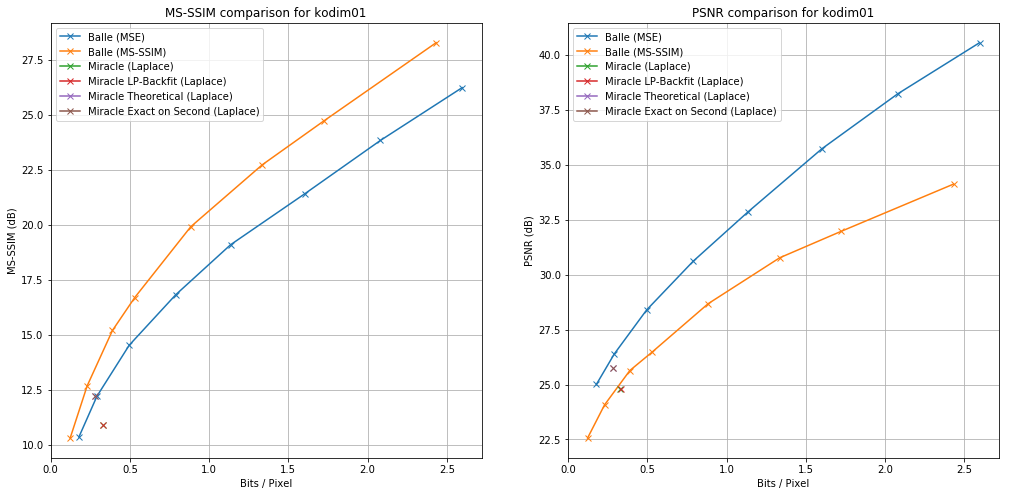

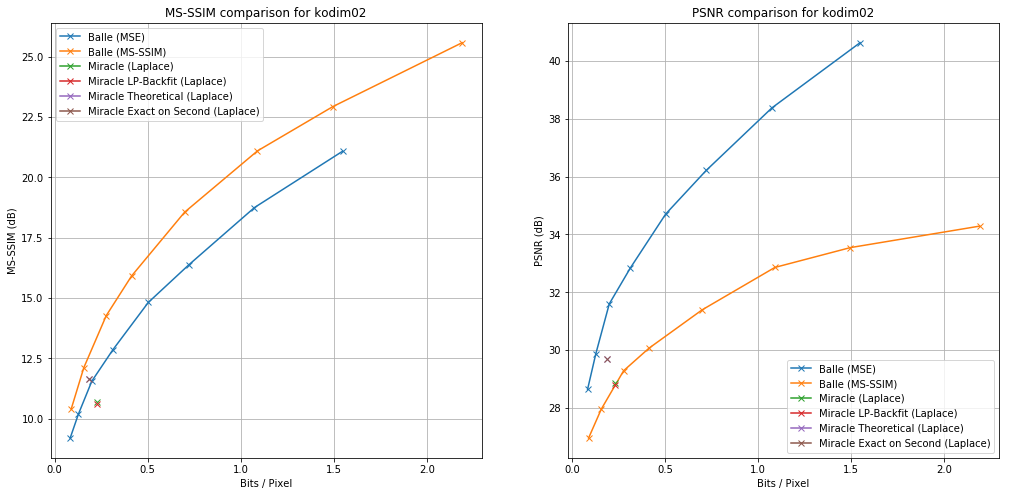

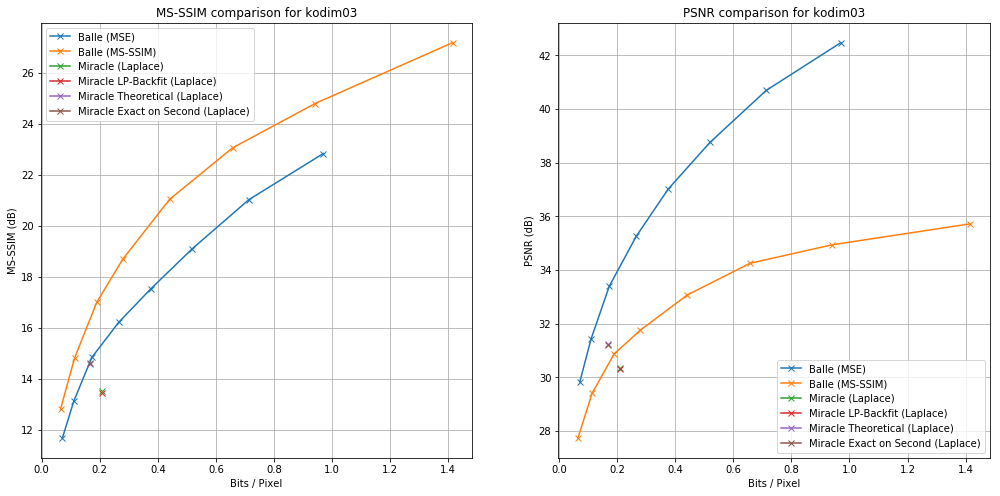

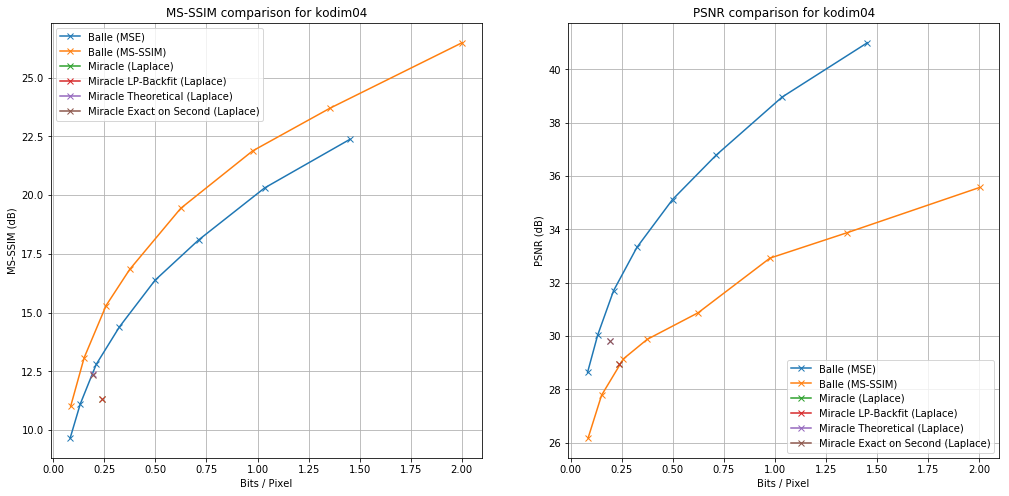

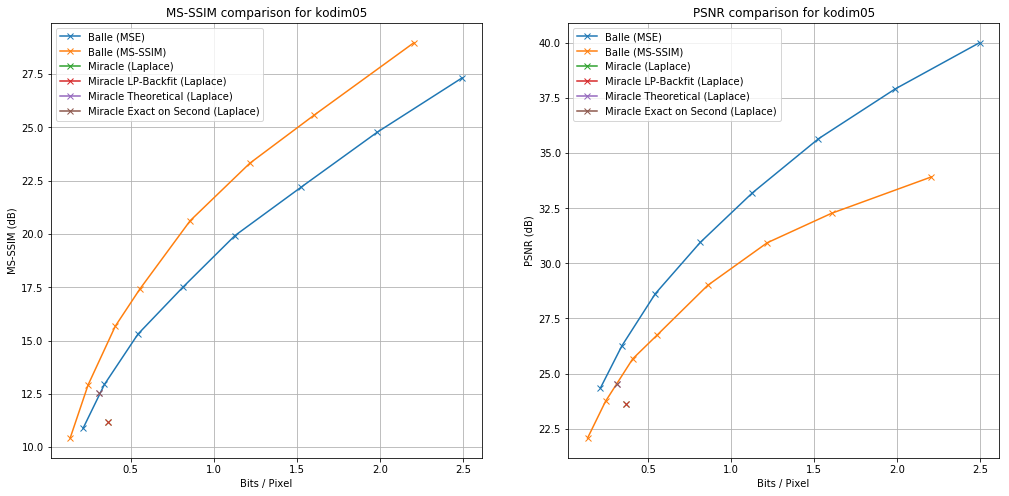

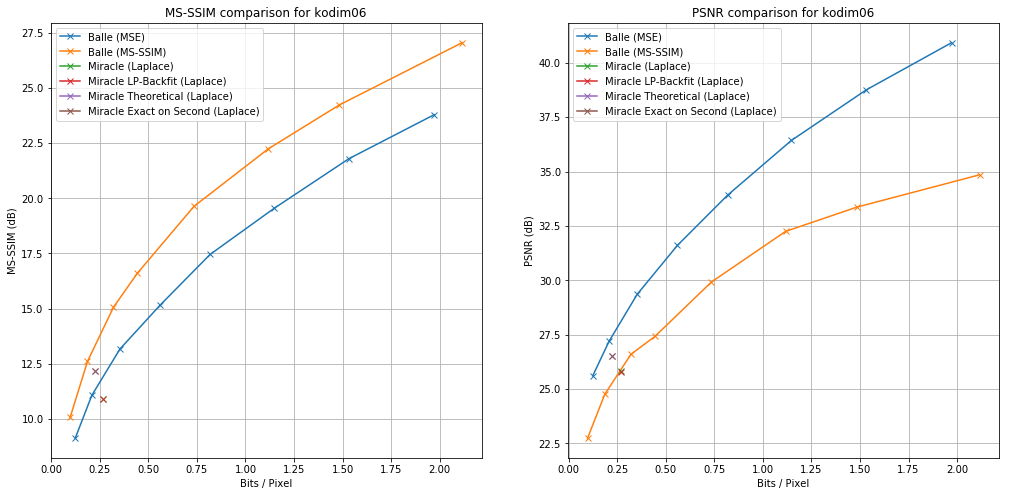

KeyboardInterrupt: 

In [22]:
ssim_to_db = lambda ssim: -10 * np.log(1 - ssim) / np.log(10)

kodak_im_format="kodim{:02d}"

for i, ((m_ssim, m_psnr), 
        (s_ssim, s_psnr), 
        (mir_ssim, mir_psnr), 
        (mir_theo_ssim, mir_theo_psnr),
        (mir_half_theo_ssim, mir_half_theo_psnr),
        (mir_backfit_lp_ssim, mir_backfit_lp_psnr)) in enumerate(kodak_info_ds):
    
    m_bpp = np.array(mse_df.iloc[i, 1:], dtype=np.float32)
    s_bpp = np.array(ssim_df.iloc[i, 1:], dtype=np.float32)
    mir_bpp = np.array(kodak_miracle_df.iloc[i, 1:], dtype=np.float32)
    
    mir_backfit_lp_bpp = np.array(kodak_miracle_backfit_lp_df.iloc[i, 1:2], dtype=np.float32)
    
    mir_theo_bpp = np.array(kodak_miracle_theoretical_df.iloc[i, 1:], dtype=np.float32)
    
    plt.figure(figsize=(17, 8))
    plt.subplot(121)
    plt.title("MS-SSIM comparison for " + kodak_im_format.format(i + 1))
    plt.plot(m_bpp, ssim_to_db(m_ssim.numpy()), marker='x', label="Balle (MSE)")
    plt.plot(s_bpp, ssim_to_db(s_ssim.numpy()), marker='x', label="Balle (MS-SSIM)")
    plt.plot(mir_bpp, ssim_to_db(mir_ssim.numpy()), marker='x', label="Miracle (Laplace)")
    plt.plot(mir_backfit_lp_bpp, ssim_to_db(mir_backfit_lp_ssim.numpy()), marker='x', label="Miracle LP-Backfit (Laplace)")
    plt.plot(mir_theo_bpp, ssim_to_db(mir_theo_ssim.numpy()), marker='x', label="Miracle Theoretical (Laplace)")
    plt.plot(mir_theo_bpp, ssim_to_db(mir_half_theo_ssim.numpy()), marker='x', label="Miracle Exact on Second (Laplace)")
    
    plt.xlabel("Bits / Pixel")
    plt.ylabel("MS-SSIM (dB)")
    plt.grid(True)
    
    plt.legend()
    
    plt.subplot(122)
    plt.title("PSNR comparison for " + kodak_im_format.format(i + 1))
    plt.plot(m_bpp, m_psnr.numpy(), marker='x', label="Balle (MSE)")
    plt.plot(s_bpp, s_psnr.numpy(), marker='x', label="Balle (MS-SSIM)")
    plt.plot(mir_bpp, mir_psnr.numpy(), marker='x', label="Miracle (Laplace)")
    plt.plot(mir_backfit_lp_bpp, mir_backfit_lp_psnr.numpy(), marker='x', label="Miracle LP-Backfit (Laplace)")
    plt.plot(mir_theo_bpp, mir_theo_psnr.numpy(), marker='x', label="Miracle Theoretical (Laplace)")
    plt.plot(mir_theo_bpp, mir_half_theo_psnr.numpy(), marker='x', label="Miracle Exact on Second (Laplace)")
    
    plt.xlabel("Bits / Pixel")
    plt.ylabel("PSNR (dB)")
    plt.grid(True)
    
    plt.legend()
    
    plt.savefig("../../img/plots/kodak_comparison/" + kodak_im_format.format(i + 1) + "_comparison.png")
    
    plt.show()